# Hyperbolic PDEs

Einstein's equations behave like *wave equations*, $\partial_{tt} \phi = \nabla^2 \phi$. 

Use first order form

$$
\frac{\partial}{\partial t} \begin{pmatrix} \phi \\ \phi_t \\ \phi_x \end{pmatrix} = \begin{pmatrix} \phi_t \\ 0 \\ 0 \end{pmatrix} + \frac{\partial}{\partial x} \begin{pmatrix} 0 \\ \phi_x \\ \phi_t \end{pmatrix}.
$$

## Method of Lines (MoL)

Convert a first order system

$$
  \partial_t {\bf u} = {\bf s} + \partial_x {\bf f}({\bf u})
$$

into an ODE


$$
  \frac{d}{d t} {\bf U}_i = {\bf s}({\bf U}_i) + L({\bf U}_i)
$$

by discretising (differencing) in space, not time. Then apply eg Runge-Kutta in time.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
def RHS(U, dx):
    """
    RHS term.
    
    Parameters
    ----------
    
    U : array
        contains [phi, phi_t, phi_x] at each point
    dx : double
        grid spacing
        
    Returns
    -------
    
    dUdt : array
        contains the required time derivatives
    """
    
    phi = U[0, :]
    phi_t = U[1, :]
    phi_x = U[2, :]
    
    dUdt = numpy.zeros_like(U)
    
    dUdt[0, :] = phi_t
    dUdt[1, 1:-1] = 1.0 / (2.0*dx)*(phi_x[2:] - phi_x[:-2])
    dUdt[2, 1:-1] = 1.0 / (2.0*dx)*(phi_t[2:] - phi_t[:-2])
    
    return dUdt

## Key code steps

We'll need

* Grid
* Initial and boundary conditions
* Right hand side (RHS) function
* Time stepping.

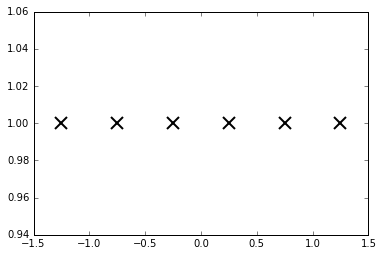

In [3]:
def grid(Npoints):
    
    dx = 2.0 / Npoints
    return dx, numpy.linspace(-1.0-dx/2.0, 
                               1.0+dx/2.0, Npoints+2)

pyplot.figure()
dx, x = grid(4)
pyplot.plot(x, numpy.ones_like(x), 'kx', ms=12, mew=2)
pyplot.show()

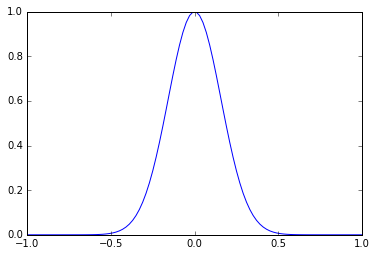

In [4]:
def initial_data(x):
    
    U = numpy.zeros((3, len(x)))
    U[0, :] = numpy.exp(-20.0 * x**2)
    U[2, :] = -40.0*x*numpy.exp(-20.0 * x**2)
    
    return U

pyplot.figure()
dx, x = grid(100)
U = initial_data(x)
pyplot.plot(x, U[0, :], 'b-')
pyplot.xlim(-1, 1)
pyplot.show()

In [5]:
def apply_boundaries(dUdt):
    """
    Periodic boundaries applied to the RHS directly.
    """
    
    dUdt[:, 0] = dUdt[:, -2]
    dUdt[:, -1] = dUdt[:, 1]
    return dUdt

def RK2_step(U, RHS, apply_boundaries, dt, dx):
    
    rhs = apply_boundaries(RHS(U, dx))
    Up = U + dt * rhs
    rhs_p = apply_boundaries(RHS(Up, dx))
    Unew = 0.5 * (U + Up + dt * rhs_p)
    return Unew

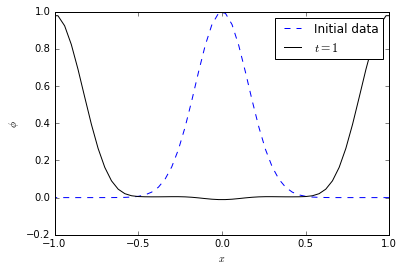

In [6]:
Npoints = 50
dx, x = grid(Npoints)
dt = dx / 4
U0 = initial_data(x)
U = initial_data(x)
Nsteps = int(1.0 / dt)
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt, dx)

pyplot.figure()
pyplot.plot(x, U0[0, :], 'b--', label="Initial data")
pyplot.plot(x, U[0, :], 'k-', label=r"$t=1$")
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$\phi$")
pyplot.xlim(-1, 1)
pyplot.legend()
pyplot.show()

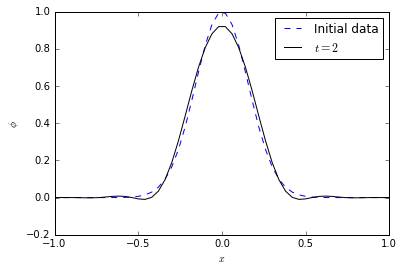

In [7]:
U = initial_data(x)
Nsteps = int(2.0 / dt)
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    
pyplot.figure()
pyplot.plot(x, U0[0, :], 'b--', label="Initial data")
pyplot.plot(x, U[0, :], 'k-', label=r"$t=2$")
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$\phi$")
pyplot.xlim(-1, 1)
pyplot.legend()
pyplot.show()

## Convergence

To check convergence, look at the error norm

$$
  \| {\cal E} \|_p = \left( \tfrac{1}{N} \sum_{i=1}^N \left( \phi_i - \phi^{\text{exact}}_i \right)^p \right)^{1/p}.
$$

We know exact solution at $t=2$ is the initial data.

In [8]:
def error_norms(U, U_initial):
    """
    Error norms (1, 2, infinity)
    """
    
    N = len(U)
    error_1 = numpy.sum(numpy.abs(U - U_initial))/N
    error_2 = numpy.sqrt(numpy.sum((U - U_initial)**2)/N)
    error_inf = numpy.max(numpy.abs(U - U_initial))
    
    return error_1, error_2, error_inf

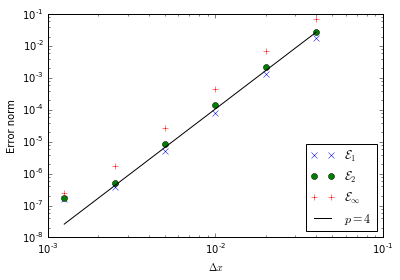

In [9]:
Npoints_all = 50 * 2**(numpy.arange(0, 6))
dxs = numpy.zeros((len(Npoints_all,)))
wave_errors = numpy.zeros((3, len(Npoints_all)))

for i, Npoints in enumerate(Npoints_all):
    dx, x = grid(Npoints)
    dt = dx / 4
    U0 = initial_data(x)
    U = initial_data(x)
    Nsteps = int(2.0 / dt)
    for n in range(Nsteps):
        U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    dxs[i] = dx
    wave_errors[:, i] = error_norms(U[0, :], U0[0, :])

pyplot.figure()
pyplot.loglog(dxs, wave_errors[0, :], 'bx', label=r"${\cal E}_1$")
pyplot.loglog(dxs, wave_errors[1, :], 'go', label=r"${\cal E}_2$")
pyplot.loglog(dxs, wave_errors[2, :], 'r+', label=r"${\cal E}_{\infty}$")
pyplot.loglog(dxs, wave_errors[1, 0]*(dxs/dxs[0])**4, 'k-', label=r"$p=4$")
pyplot.xlabel(r"$\Delta x$")
pyplot.ylabel("Error norm")
pyplot.legend(loc="lower right")
pyplot.show()

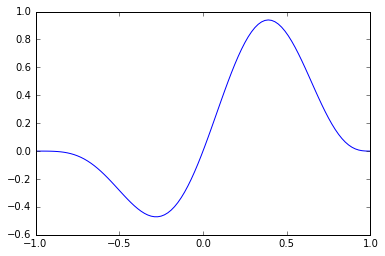

In [10]:
def initial_data_asymmetric(x):
    
    U = numpy.zeros((3, len(x)))
    U[0, :] = numpy.sin(numpy.pi*x)*(1-x)**2*(1+x)**3
    U[2, :] = numpy.pi*numpy.cos(numpy.pi*x)*(1-x)**2*(1+x)**3 + \
              numpy.sin(numpy.pi*x)*(2.0*(1-x)*(1+x)**3 + \
                                     3.0*(1-x)**2*(1+x)**2)
    
    return U

pyplot.figure()
dx, x = grid(100)
U = initial_data_asymmetric(x)
pyplot.plot(x, U[0, :], 'b-')
pyplot.xlim(-1, 1)
pyplot.show()

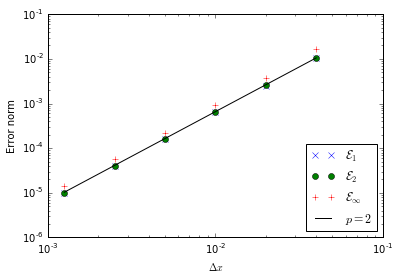

In [11]:
Npoints_all = 50 * 2**(numpy.arange(0, 6))
dxs = numpy.zeros((len(Npoints_all,)))
wave_errors = numpy.zeros((3, len(Npoints_all)))

for i, Npoints in enumerate(Npoints_all):
    dx, x = grid(Npoints)
    dt = dx / 4
    U0 = initial_data_asymmetric(x)
    U = initial_data_asymmetric(x)
    Nsteps = int(2.0 / dt)
    for n in range(Nsteps):
        U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    dxs[i] = dx
    wave_errors[:, i] = error_norms(U[0, :], U0[0, :])
    
pyplot.figure()
pyplot.loglog(dxs, wave_errors[0, :], 'bx', label=r"${\cal E}_1$")
pyplot.loglog(dxs, wave_errors[1, :], 'go', label=r"${\cal E}_2$")
pyplot.loglog(dxs, wave_errors[2, :], 'r+', label=r"${\cal E}_{\infty}$")
pyplot.loglog(dxs, wave_errors[1, 0]*(dxs/dxs[0])**2, 'k-', label=r"$p=2$")
pyplot.xlabel(r"$\Delta x$")
pyplot.ylabel("Error norm")
pyplot.legend(loc="lower right")
pyplot.show()

## Courant limits

We restricted the timestep to $\Delta t = \sigma \Delta x$ with $\sigma$, the *Courant number*, being $1/4$. 

Number of timesteps taken is inversely related to the Courant number: want to make it as large as possible. 

Let's try the evolution with Courant number $\sigma=1$.

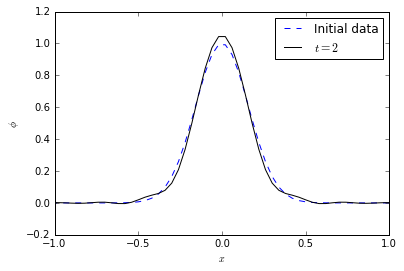

In [12]:
Npoints = 50
dx, x = grid(Npoints)
dt = dx # This is the crucial line
U0 = initial_data(x)
U = initial_data(x)
Nsteps = int(2.0/dt)
for n in range(Nsteps):
    U = RK2_step(U, RHS, apply_boundaries, dt, dx)
    
pyplot.figure()
pyplot.plot(x, U0[0, :], 'b--', label="Initial data")
pyplot.plot(x, U[0, :], 'k-', label=r"$t=2$")
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$\phi$")
pyplot.xlim(-1, 1)
pyplot.legend()
pyplot.show()

### Courant limit

Hyperbolic PDEs have a Courant *limit*: $\Delta t$ too large is unstable. This depends on physics and numerics. Typically a maximum limit is

$$
  \sigma < \frac{1}{\sqrt{D} \lambda_{\text{max}}}
$$

($D$ is number of spatial dimensions, $\lambda_{\text{max}}$ the maximum characteristic speed).

# Exercises

1. Try the second order in space form (relevant for BSSN).
2. Try fourth order differencing in space. What convergence rate do you get? Why?
3. Try third order differencing in time. When does this help?